# 1. Setup

In [1]:
# common imports
import pandas as pd
import numpy as np
import os

# Q.2 SQL Skills Assessment

## 2.1 Create a Table, Run a Simple Query

"Create your own employee table in the following format: EMPLOYEE_ID, NAME, PROFESSION. How do you generate a new table with number of employees in each of the following categories of professions: IT, SALES and OTHER?"

In [2]:
n_empl = 2000

I create a tables with employees using `pandas` and `randint` method from `numpy.random`

In [3]:
# check how it looks
np.random.seed(42)
# EMPLOYEE_ID varies from 1000000 to 10000000,
# NAME is generated randomly out of 2-digit integers (see below),
# PROFESSION is selected out of 10 (see a dictionary below)
np.random.randint(low=[100000, 1, 1], high=[1000000, 100, 11], size=(10, 3))

array([[221958,     52,      8],
       [210268,     21,      7],
       [237337,     83,      7],
       [187498,     88,      5],
       [275203,     24,      3],
       [429365,     53,      2],
       [421879,     30,      6],
       [299041,     64,      5],
       [314176,     76,     10],
       [521909,     89,      1]])

In [4]:
prof_dict = {1: "FREELANCER",
            2: "RESEARCHER",
            3: "ACCOUNTANT",
            4: "DOCTOR",
            5: "IT",
            6: "SALES",
            7: "MANAGER",
            8: "SERVICE",
            9: "ENGINEER",
            10: "OTHER"}

np.random.seed(42)
my_df = pd.DataFrame(np.random.randint(low=[100000, 10, 1], high=[1000000, 100, 11], size=(n_empl, 3)),
             columns = ["EMPLOYEE_ID", "NN", "PROF_ID"])
my_df

,EMPLOYEE_ID,NN,PROF_ID
0,221958,61,8
1,210268,30,7
2,237337,92,7
3,187498,97,5
4,275203,33,3
...,...,...,...
1995,682111,25,5
1996,700724,87,7
1997,659070,87,6
1998,340011,25,1


In [5]:
my_df["PROFESSION"] = my_df["PROF_ID"].map(prof_dict)
# make name be a repetition of characters:
# if an integer is YZ, then the first name is Y times a letter that corresponds to Y
# and the last name Z times a letter that corresponds to Z
my_df["NAME"] = [
    chr(ord('@') + cval//10)*(cval//10)
    + " " + chr(ord('@') + cval%10)*(cval%10)
    for cval in my_df["NN"].values
]
my_df

,EMPLOYEE_ID,NN,PROF_ID,PROFESSION,NAME
0,221958,61,8,SERVICE,FFFFFF A
1,210268,30,7,MANAGER,CCC
2,237337,92,7,MANAGER,IIIIIIIII BB
3,187498,97,5,IT,IIIIIIIII GGGGGGG
4,275203,33,3,ACCOUNTANT,CCC CCC
...,...,...,...,...,...
1995,682111,25,5,IT,BB EEEEE
1996,700724,87,7,MANAGER,HHHHHHHH GGGGGGG
1997,659070,87,6,SALES,HHHHHHHH GGGGGGG
1998,340011,25,1,FREELANCER,BB EEEEE


I had to set up the database manually using the MS SQL Server 2019, so I imported the dataframe into a CSV file

In [6]:
my_df[["EMPLOYEE_ID", "NAME", "PROFESSION"]].to_csv("employees.csv")

I import this csv file into a local SQL database using "SQL Server 2019 Import and Export Tool".

Then I run the following query:
```mysql
SELECT PROFESSION, count(EMPLOYEE_ID) FROM employees
	-- -- AN ALTERNATIVE WOULD BE:
	-- where (PROFESSION like '%IT%' OR PROFESSION like '%OTHER%' OR PROFESSION like '%SALES%')
	where (PROFESSION = 'IT' OR PROFESSION = 'OTHER' OR PROFESSION = 'SALES') 
	group by PROFESSION    
```

"Please provide both your table and the query."

Here you go:

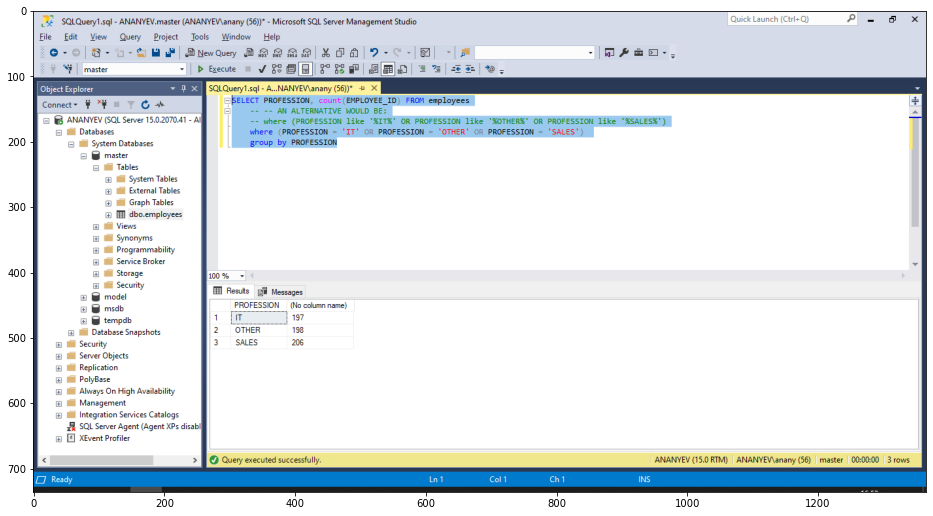

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread("screenshot1.png")
plt.figure(figsize=(16,9))
plt.imshow(img)

## 2.2 Construct a Table

"You have the following definition and the transactional tables. How do you construct the output table with the columns “date, #new_users, #active_users, #churn_users, #reactivated_users” in SQL? In the definition table (user_status_table), “x” represents activity, “-“ represents no activity and “NA” represents when it’s not important."

user_status | Activity before 60d | Activity 30-60d ago | Activity in last 30d
------------|---------------------|---------------------|---------------------
new         | -                   | -                   | X
active      | NA                  | X                   | X
churned     | NA                  | X                   | -
reactivated | X                   | -                   | X

### Problems
This formulation implies that same users can change their status as time runs.
There is no information about the time frequency, so I assumed it can be arbitrary.
Moreover, it is not clear whether there can be duplicates in the `activity_table`.

**Note:** Without loss of generality, I assume that the `activity_table` does not contain any duplicates. In case there are duplicates, we can first exclude those by creating a new `activity_table2` without any duplicates and use it instead.
To create a (temp) copy of a table without date-user duplicates, run:

```mysql
SELECT DISTINCT convert(date, date) as date_ymd, user_id
    INTO activity_table2
    FROM activity_table
```

**WARNING:** The column names `user_id` and `date` are bad since they are reserved system names.
I will write the queries using these names, however, in a real database you should avoid naming your columns like that.

### Idea
I do not know whether there exist a way to create a classifier and then simply count entries that are produced by this classifier.
Nevertheless, I have the following idea.

* For each date, I can calculate whether the user was active on that date.
    For each user, I can calculate the date when that user was active for the first/last time.
    - I can calculate how long has passed since the user was last active.
        This gives me information about churned users (if 30 < time diff between the date and last activity date is < 60).
        Let's denote the table with such users as $Churned$.
    - I can calculate how long ago the user became active (for the first time).
        This gives me info on new users (first time active < 30), denoted as $New$, as well as long-time active users
        (who can be still active, churned or reactivated), denoted as $LongActive$.
        
  I, therefore, can only calculate for each date the number of new users and the number of churned ones.
  I need to distinguish between active and reactivated users.
  
* For each date, I can calculate `pDate` = `date` - 30 days.
    - Use these dates to create a temporary table `temp_activity_table` (date, pDate, user_id[pDate]).
        * For users in this temp table I can now identify who were *not* active 30 days before pDate,
            denote those as $\#Gap30to60$.
        * These are candidates for reactivated users:
            $Reactivated = (LongActive \backslash Churned) \cap \#Gap30to60$.
        * The rest are reactivated: $Active = (LongActive \backslash Churned) \backslash Reactivated$.
        
**Note:** I will use the definitions given in the `user_status` table, i.e. calculate difference between two dates in *days*, not in months.

### Script
The following script should do the job.

```mysql
-------------------------------------------------------------------------------
-- Delete a table if it exists
-- (just for convenience)
IF OBJECT_ID('tempdb.dbo.#activity2', 'U') IS NOT NULL 
	DROP TABLE #activity2 ;

-- Create a table without day-user duplicates
SELECT DISTINCT convert(date, date) AS dat, user_id
	INTO #activity2
	FROM activity ;


-------------------------------------------------------------------------------
-- Make a table with the lag(date) - for each date make an entry when the user was active last time
SELECT a.user_id, a.dat,
		lag(dat) OVER(PARTITION BY user_id ORDER BY dat) as prev_date
	FROM #activity2 a
	ORDER BY user_id, dat ;

-- For convenience
IF OBJECT_ID('dbo.GAP30p', 'U') IS NOT NULL 
	DROP TABLE dbo.GAP30p ;

-- Create a table "GAP30p" whith users that were last active more that 30 days ago compared to the date we observe them again
SELECT b.user_id, b.dat, b.prev_date, datediff(d, b.prev_date, b.dat) as gap
	INTO GAP30p
	FROM (
		SELECT user_id, dat,
				lag(dat) OVER(PARTITION BY user_id ORDER BY dat) as prev_date
			FROM #activity2
	) b
	WHERE datediff(d, b.prev_date, b.dat) > 30
	ORDER BY user_id, dat ;

-- See the result
--select * from GAP30p order by user_id, dat ;


-------------------------------------------------------------------------------
-- CROSS-JOINT Table with all users on all dates
IF OBJECT_ID('tempdb.dbo.#ct', 'U') IS NOT NULL 
	DROP TABLE #ct ;

SELECT *
	INTO #ct
	FROM (
		SELECT DISTINCT dat as dates
			FROM #activity2
	) a
	CROSS JOIN (
		SELECT DISTINCT user_id
		FROM #activity2
	) b ;


-------------------------------------------------------------------------------
-- For convenience
IF OBJECT_ID('dbo.Churned', 'U') IS NOT NULL 
	DROP TABLE dbo.Churned ; 

-- Create a table ("Churned") that shows for each possible date all the users that were churned at that date
SELECT #ct.dates, #ct.user_id, g.dat AS appeared_again, g.prev_date as last_appear, g.gap as absence_period
	INTO Churned
	FROM #ct
	RIGHT JOIN GAP30p g
	ON #ct.user_id = g.user_id
	WHERE datediff(d, g.dat, #ct.dates) < 0 and datediff(d, g.prev_date, #ct.dates) > 30
	ORDER BY #ct.user_id, #ct.dates, g.dat ;

-- See the result
--select * from Churned ORDER BY dates, user_id ;



-------------------------------------------------------------------------------
-- For convenience
IF OBJECT_ID('dbo.New', 'U') IS NOT NULL 
	DROP TABLE dbo.New ;

-- Create a table ("New") that shows for each possible date all the users that were first time active less than 30d ago
SELECT #ct.dates, #ct.user_id, f.first_active, datediff(d, f.first_active, #ct.dates) AS activity_length
	INTO New
	FROM #ct
	RIGHT JOIN (
		SELECT DISTINCT user_id,
				min(dat) OVER(PARTITION BY user_id ORDER BY dat) as first_active
			FROM #activity2
	) f
	ON #ct.user_id = f.user_id
	WHERE datediff(d, f.first_active, #ct.dates) < 30 AND datediff(d, f.first_active, #ct.dates) >= 0
	ORDER BY #ct.user_id, #ct.dates ;

-- See the result
--select * from New ORDER BY dates, user_id ;



-------------------------------------------------------------------------------
-- first time active more than 30d ago
IF OBJECT_ID('dbo.LongActive', 'U') IS NOT NULL 
	DROP TABLE dbo.LongActive ;

SELECT #ct.dates, #ct.user_id, f.first_active,
		datediff(d, f.first_active, #ct.dates) AS activity_length
	INTO LongActive
	FROM #ct
	RIGHT JOIN (
		SELECT DISTINCT user_id,
				min(dat) OVER(PARTITION BY user_id ORDER BY dat) as first_active
			FROM #activity2
	) f
	ON #ct.user_id = f.user_id
	WHERE datediff(d, f.first_active, #ct.dates) >= 30
	ORDER BY #ct.user_id, #ct.dates ;

-- See the result
--SELECT * FROM LongActive ORDER BY user_id, dates ;


-- just a table with lagged dates
IF OBJECT_ID('tempdb.dbo.#lagdates', 'U') IS NOT NULL 
	DROP TABLE #lagdates ;

SELECT #ct.dates,
		CONVERT(date, CONVERT(datetime, #ct.dates) - 30) AS pDate,
		#ct.user_id
	INTO #lagdates
	FROM #ct
	WHERE CONVERT(date, CONVERT(datetime, #ct.dates) - 30) >= '2000-01-01'
	ORDER BY dates, pDate, user_id ;

-- See the result
--SELECT * FROM #lagdates ORDER BY dates, user_id ;



-------------------------------------------------------------------------------
-- from a 30d ago point of view, these users were absent for 30 days
IF OBJECT_ID('dbo.GAP30to60', 'U') IS NOT NULL 
	DROP TABLE dbo.GAP30to60 ;

SELECT #lagdates.dates, #lagdates.pDate, #lagdates.user_id,
		g.dat AS appeared_again, g.prev_date as last_appear, g.gap as absence_period
	INTO GAP30to60
	FROM #lagdates
	RIGHT JOIN GAP30p g
	ON #lagdates.user_id = g.user_id
	WHERE datediff(d, g.dat, #lagdates.pDate) < 0 and datediff(d, g.prev_date, #lagdates.pDate) > 30
	ORDER BY #lagdates.user_id, #lagdates.dates, g.dat ;

-- Show the result
--SELECT * FROM GAP30to60 ORDER BY user_id, dates, pDate, appeared_again ;



-------------------------------------------------------------------------------
-- Reactivated users are those who are not in Churned but are in GAP30to60
IF OBJECT_ID('dbo.Reactivated', 'U') IS NOT NULL 
	DROP TABLE dbo.Reactivated ;

SELECT la_no_c.*, g.pDate, g.appeared_again, g.last_appear, g.absence_period
	INTO Reactivated
	FROM (
		SELECT la.*
			FROM LongActive la
			LEFT JOIN Churned c
				ON la.dates = c.dates and la.user_id = c.user_id
				WHERE c.user_id IS NULL AND c.dates IS NULL
	) la_no_c
	INNER JOIN GAP30to60 g
		ON la_no_c.dates = g.dates AND la_no_c.user_id = g.user_id
	ORDER BY la_no_c.dates, la_no_c.user_id ;

-- Show the result
--select * from Reactivated order by dates, user_id ;



-------------------------------------------------------------------------------
-- Active users are those who are not in Churned AND not Reactivated
IF OBJECT_ID('dbo.Active', 'U') IS NOT NULL 
	DROP TABLE dbo.Active ;

SELECT la_no_c.*
	INTO Active
	FROM (
		SELECT la.*
			FROM LongActive la
			LEFT JOIN Churned c
				ON la.dates = c.dates and la.user_id = c.user_id
				WHERE c.user_id IS NULL AND c.dates IS NULL
	) la_no_c
	LEFT JOIN Reactivated r
		ON la_no_c.dates = r.dates AND la_no_c.user_id = r.user_id
		WHERE r.user_id IS NULL AND r.dates IS NULL 
	ORDER BY la_no_c.dates, la_no_c.user_id ;

-- Show the result
--select * from Active order by dates, user_id ;



-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-- FINAL TABLE WITH:
-- * date, #new_users, #active_users, #churn_users, #reactivated_users
SELECT #ct.dates,
		count(n.user_id) as '#new_users',
		count(a.user_id) as '#active_users',
		count(c.user_id) as '#churn_users',
		count(r.user_id) as '#reactivated_users'
	FROM #ct
		FULL OUTER JOIN New n
			ON #ct.dates = n.dates AND #ct.user_id = n.user_id
		FULL OUTER JOIN Active a
			ON #ct.dates = a.dates AND #ct.user_id = a.user_id
		FULL OUTER JOIN Churned c
			ON #ct.dates = c.dates AND #ct.user_id = c.user_id
		FULL OUTER JOIN Reactivated r
			ON #ct.dates = r.dates AND #ct.user_id = r.user_id
	GROUP BY #ct.dates
	ORDER BY #ct.dates

```

I tested the script on the data, generated as follows.

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# id, Year, Month, Day
np.random.seed(42)
a = np.random.randint(low=[1, 2000, 1, 1], high=[100, 2001, 13, 29], size=(1000, 4))
d = [dt.datetime(row[0], row[1], row[2]) for row in a[:, 1:]]
df = pd.DataFrame(np.c_[a[:, 0], d])
df.columns = ['user_id', 'date']

df.sort_values(by='date', axis=0).to_csv("activity.csv")

Again, I imported the CSV file into a MS SQL Server 2019 using Import/Export tool.

After running the SQL query presented above (it is also saved in the `Q2.2.sql` file), I saved the output into `result.csv`.
Here I pring its content (partially, as pandas crops middle lines by default).

In [9]:
import pandas as pd
result = pd.read_csv('result.csv', delimiter=';', header=None, names=[
    "date", '#new_users', '#active_users', '#churn_users', '#reactivated_users'])
result

,date,#new_users,#active_users,#churn_users,#reactivated_users
0,2000-01-01,2,0,0,0
1,2000-01-02,4,0,0,0
2,2000-01-03,7,0,0,0
3,2000-01-04,8,0,0,0
4,2000-01-05,14,0,0,0
...,...,...,...,...,...
315,2000-12-24,0,71,6,22
316,2000-12-25,0,72,5,22
317,2000-12-26,0,74,2,23
318,2000-12-27,0,76,2,21


## 2.3 Joining Tables

### a. Identify the users that are not in the first table but are in the second table

First table - `users_table` with fields: `user_id`, `name`, and `gender`.

Second table - `transaction_table` with fields: `index`, `user_id`, `age`, and `weight`.

```mysql
SELECT transaction_table.user_id FROM transaction_table
    LEFT JOIN users_table
    ON transaction_table.user_id = users_table.user_id
    WHERE users_table.user_id IS NULL
```

### b. Join the two tables with only one record for duplicates

I surmise that the task is to make a union of the two tables, just avoid the duplicates (FULL OUTER JOIN). I furthermore assume that the `users_table` does not contain any duplicates (that is only `transaction_table` has duplicates).

```mysql
-- pick all columns from *transaction_table*, *users_table*, and a table that defines unique *user_id*
SELECT t1.*, u.* FROM transaction_table t1
    -- use only *user_id* that appear in the table with unique values
    INNER JOIN (
        -- pick unique *user_id* in *transaction_table*
        SELECT DISTINCT user_id FROM transaction_table
        ) t2
    ON t1.user_id = t2.user_id
    FULL OUTER JOIN (
        SELECT * FROM users_table
        ) u
    ON t2.user_id = u.user_id
```

### c. Explain your assumptions and approach

See discussion in previous task.

### d. Find how many unique names for each gender category do we have in the `users_table`

```mysql
SELECT gender, COUNT(name) FROM (
    -- this table here starts counting how many times a name appears among users of a given gender
	SELECT gender, name, row_number() OVER (PARTITION BY gender, name ORDER BY name) AS seqnum FROM users_table
	) h
-- so, basically, we pick only the first occurence of each name and count them
WHERE h.seqnum = 1
GROUP BY gender
```